<a href="https://colab.research.google.com/github/dkrieger94/intro/blob/master/EarthSystemModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numbers
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import simps

from scipy.special import erf

import matplotlib.pyplot as plt

# Some useful time conversion factors
seconds_per_minute = 60.
minutes_per_hour = 60.
hours_per_day = 24.
days_per_year = 365.2422
seconds_per_hour = minutes_per_hour * seconds_per_minute
minutes_per_day = hours_per_day * minutes_per_hour
seconds_per_day = hours_per_day * seconds_per_hour
seconds_per_year = seconds_per_day * days_per_year

A = 204.  # Budyko Sellers approximation constants (W / m**2)
B = 2.17

a = 5.4  # constant for OLR modification by CO2 (W / m**2)

sigma = 5.6703726226e-08  # Stefan-Boltzmann constant (W / m**2 / K**4)
S0 = 1365.2  # solar constant (W / m**2)
emss = 0.6  # atmosphere emissivity

rho_w = 1028.  # density of water (kg / m**3)
cw = 4200.  # specific heat of liquid water (J / kg / K)

Ts_0 = 286.73  # estimated global mean temperature (1850-1900 avg)

# carbon cycle
k_a = 2.12  # (GtC / ppm) ---> atmosphere

co2 = 280.  # pre-industrial atmospheric CO2 concentration (ppm)
g_e = 0.005 / seconds_per_year  # (GtC / ppm) / s
ge_ka = g_e / k_a  # 1 / s
zeta = 10.5
mu_0 = 5.0 / seconds_per_year  # Ocean carbon transfer rate (m / s)

tau_l = 41. * seconds_per_year  # reference lifetime of land carbon (yr)
q_10 = 1.8  # increase in respiration with a 10K temp. increase
beta_fertil = 0.4  # CO2 fertilization factor
npp_0 = 60. / seconds_per_year  # pre-industrial net primary productivity (GtC / yr)
cl_0 = 2500.  # pre-industrial land carbon storage (GtC)

emss_0 = 36. / seconds_per_year  # (GtC / s)


class ESM:

    def __init__(self,
                 initial_state=None,
                 insolation=0.25 * S0,
                 albedo_atm=0.0,
                 albedo_land=0.29,
                 albedo_icefree=0.2,
                 albedo_ice=0.6,
                 albedo_ref_temperature=273.15,
                 albedo_b=0.05,
                 albedo_carbon_coeff=-0.01,
                 emissivity=emss,
                 emissivity_gradient=0.01,
                 emissivity_t_ref=288.,
                 depth_s=75.0,
                 depth_d=3750.0,
                 emissions_scenario=None,
                 transient_rad_resp=0.0,
                 mixing_scale=3.2,
                 lin_olr=False,
                 use_constant_albedo_land=True,
                 use_constant_albedo_icefree=True,
                 use_constant_emissivity=True,
                 reference_year=1850,
                 active_components=3):

        # albedo parameters
        if initial_state is None:
            initial_state = {'ts': Ts_0, 'td': Ts_0 - 10}
        self.albedo_atm = albedo_atm  # atmospheric albedo
        self.albedo_land = albedo_land
        self.albedo_icefree = albedo_icefree  # land albedo in hothouse climate
        self.albedo_ice = albedo_ice  # land albedo in snowball climate
        self.albedo_ref_temperature = albedo_ref_temperature  # reference temperature for albedo transition zone
        self.albedo_b = albedo_b  # albedo error function tuning parameter
        self.albedo_carbon_coeff = albedo_carbon_coeff  # albedo dependence on carbon
        self.use_constant_albedo_land = use_constant_albedo_land
        self.use_constant_albedo_icefree = use_constant_albedo_icefree

        self.insolation = insolation
        self.lin_olr = lin_olr

        # emissivity
        self.emss = emissivity
        self.emss_gradient = emissivity_gradient  # change in emissivity with temperature (1 / K)
        self.emss_t_ref = emissivity_t_ref  # reference temperature for which emissivity = self.emss
        self.use_constant_emissivity = use_constant_emissivity

        # atmosphere-ocean coupling parameters
        self.eta = mixing_scale
        self.lambda_t = transient_rad_resp

        # pre-industrial ocean carbon storage [ GtC ]

        self.nu_o = 1./6.   # ocean-atmosphere carbon ratio
        self.cl_0 = cl_0
        self.ca_0 = co2 * k_a
        self.co_0 = zeta * self.ca_0 / self.nu_o
        self.cs_0 = self.co_0 * depth_s / (depth_s + depth_d)
        self.cd_0 = self.co_0 - self.cs_0
        self.nu_s = zeta * self.ca_0 / self.cs_0 # surface-atmosphere carbon ratio

        # Anthropogenic emissions
        self.reference_year = reference_year
        self.Ts_0 = Ts_0  # estimated global mean temperature (1850-1900 avg)

        if emissions_scenario is None:
            emissions_scenario = emss_0

        if isinstance(emissions_scenario, numbers.Number):
            # constant emission scenario                             (GtC / yr)
            self.em = lambda t: emissions_scenario
        elif callable(emissions_scenario):
            # Time dependent function                                (GtC / yr)
            self.em = emissions_scenario
        elif hasattr(emissions_scenario, '__len__'):
            # Time series (filename / array)                         (GtC / yr)

            if isinstance(emissions_scenario, str):
                # Assuming a filename is given as string
                em_data = np.array(pd.read_csv(emissions_scenario, sep=',')).T
            else:
                em_data = np.asanyarray(emissions_scenario)

            em_data[1] /= seconds_per_year  # add unit checking of data in file
            # Create interpolation function from data points
            interp_fun = interp1d(*em_data,
                                  kind='linear', bounds_error=False,
                                  fill_value=(em_data[1, 0], em_data[1, -1]))
            self.em = lambda t: interp_fun(t)

        else:
            raise ValueError(
                "Parameter 'emissions' must be a scalar, a filename (string),"
                " a Nx2 sequence or a callable function")

        # -----------------------------------------------------------------------
        # Model state initialization:
        # -----------------------------------------------------------------------
        self.model_state = {}

        if isinstance(initial_state, dict):
            vnames = initial_state.keys()
            assert 'ts' in vnames, "Model state must contain at least 'ts'"

            self.model_state['ts'] = initial_state['ts']
            if 'td' not in vnames:
                self.model_state['td'] = initial_state['ts'] - 10.0
            else:
                self.model_state['td'] = initial_state['td']

            if 'ca' not in vnames:  # Atmospheric   carbon storage (GtC)
                self.model_state['ca'] = self.ca_0
            else:
                self.model_state['ca'] = initial_state['ca'] * k_a

            if 'cs' not in vnames:  # Surface Ocean carbon storage (GtC)
                self.model_state['cs'] = self.cs_0
            else:
                self.model_state['cs'] = initial_state['cs']

            if 'cd' not in vnames:  # Deep Ocean    carbon storage (GtC)
                self.model_state['cd'] = self.cd_0
            else:
                self.model_state['cd'] = initial_state['cd']

            if 'cl' not in vnames:  # Terrestrial   carbon storage (GtC)
                self.model_state['cl'] = self.cl_0
            else:
                self.model_state['cl'] = initial_state['cl']

        elif np.isscalar(initial_state):
            self.model_state['ts'] = initial_state
            # ocean layer initialized to be 10 degrees colder than the surface layer
            self.model_state['td'] = self.model_state['ts'] - 10.0
            self.model_state['ca'] = self.ca_0
            self.model_state['cs'] = self.cs_0
            self.model_state['cd'] = self.cd_0
            self.model_state['cl'] = self.cl_0

        else:
            raise ValueError("Wrong model initialization")

        self._update_state()

        self.num_active_components = active_components
        self.num_active_variables = np.array([1, 2, 6])[active_components - 1]

        # -----------------------------------------------------------------------
        # Integration time scales
        # -----------------------------------------------------------------------
        self.depth_s = depth_s  # characteristic depth for ts   (m)
        self.tau_s = self.depth_s * rho_w * cw  # timescale for integration

        self.depth_d = depth_d  # characteristic depth for ts   (m)
        self.tau_d = self.depth_d * rho_w * cw  # timescale for integration

    def _update_state(self):
        # create instances of state variables from init dictionary
        for k, v in self.model_state.items():
            setattr(self, k, v)
    # ---------------------------------------------------------------------------
    # ---------------   Definition Atmosphere-Ocean processes    ----------------
    # ---------------------------------------------------------------------------
    def compute_albedo(self, ts, ca):
        return self.albedo_atm + self.compute_albedo_land(ts, ca) * (1 - self.albedo_atm) ** 2

    def compute_albedo_land(self, ts, ca):
        if self.use_constant_albedo_land:
            return self.albedo_land
        else:
            tmp = erf(self.albedo_b * (ts - self.albedo_ref_temperature))
            tmp = self.albedo_ice * (1.0 - tmp) + self.compute_albedo_icefree(ca) * (1.0 + tmp)
            return tmp / 2.0

    def compute_albedo_icefree(self, ca):
        if self.use_constant_albedo_icefree:
            return self.albedo_icefree
        elif (ca / k_a) > 1.0:
            return self.albedo_icefree + self.albedo_carbon_coeff * np.log(ca / k_a)
        else:
            return self.albedo_icefree

    def compute_emissivity(self, ts):
        if self.use_constant_emissivity:
            return 1.0 - 0.5 * self.emss
        else:
            return 1.0 - 0.5 * (self.emss + self.emss_gradient * (ts - self.emss_t_ref))

    def compute_ASR(self, ts, ca):
        return self.insolation * (1 - self.compute_albedo(ts, ca))

    def compute_OLR(self, ts, ca):
        if self.lin_olr:
            return A + B * (ts - 273.15)
        if ca > k_a:
            return self.compute_emissivity(ts) * sigma * ts ** 4 - a * np.log(ca / k_a)
        else:
            return self.compute_emissivity(ts) * sigma * ts ** 4

    def compute_NRI(self, ts, ca):
        return self.compute_ASR(ts, ca) - self.compute_OLR(ts, ca)

    def compute_DSI(self, ts, td):
        return (self.eta + self.lambda_t) * (ts - td)

    # ---------------------------------------------------------------------------
    # ------------------           Carbon Cycle             ---------------------
    # ---------------------------------------------------------------------------
    @staticmethod
    def gas_exchange_rate(ts):
        # gas_exchange_rate (s^-1)
        return ge_ka

    def compute_fs(self, ts, ca, cs):
        """Ocean carbon uptake
        """
        d_ca = (ca - self.ca_0)
        d_co = self.nu_s * (cs - self.cs_0)
        return self.gas_exchange_rate(ts) * (d_ca - d_co)

    def compute_fd(self, cs, cd):
        tmp_s = (cs - self.cs_0) / self.depth_s
        tmp_d = (cd - self.cd_0) / self.depth_d
        return mu_0 * (tmp_s - tmp_d)

    def compute_fl(self, ca, cl, ts):
        return self.compute_NPP(ca) - self.compute_respiration(ts, cl)

    def compute_NPP(self, ca):
        # Here ca units must be ppm
        return npp_0 * (1.0 + beta_fertil * np.log(ca / self.ca_0))

    def compute_respiration(self, ts, cl):
        # ts must be dTs: The surface air temperature change since pre-industrial
        return (cl / tau_l) * q_10 ** ((ts - self.Ts_0) / 10.)

    # ---------------------------------------------------------------------------
    # ------------------   Model tendencies and components  ---------------------
    # ---------------------------------------------------------------------------

    # Instead of evaluating conditional statement inside 'self.compute_imbalance',
    # the model is constructed according to the number of active components

    def model_constructor(self):

        if self.num_active_components == 1:

            def _compute_imbalance(time, state):
                return self.compute_NRI(state, self.model_state['ca']) / self.tau_s

        elif self.num_active_components == 2:

            def _compute_imbalance(time, state):
                ts, td = state
                ns = self.compute_NRI(ts, self.model_state['ca']) / self.tau_s
                nd = self.compute_DSI(ts, td) / self.tau_d
                return np.array([ns - nd, nd])

        elif self.num_active_components == 3:
            # self.ca is not a state variable unless emissions are considered
            def _compute_imbalance(time, state):
                ts, td, cs, cd, cl, ca = state
                ns = self.compute_NRI(ts, ca) / self.tau_s
                nd = self.compute_DSI(ts, td) / self.tau_d

                ncs = self.compute_fs(ts, ca, cs)
                ncd = self.compute_fd(cs, cd)
                ncl = self.compute_fl(ca, cl, ts)

                return np.array([ns - nd, nd, ncs - ncd, ncd, ncl, self.em(time) - ncl - ncs])
        else:
            raise ValueError("Something went wrong when constructing the model")

        return _compute_imbalance

    # ---------------------------------------------------------------------------
    # ------------------          Model numerics            ---------------------
    # ---------------------------------------------------------------------------
    def _carbon_conservation(self, sim_time, carbon_init=0.0):
        """
        :param time: integration time span
        :param carbon_init: initial carbon storage
        """
        time = np.linspace(0.0, sim_time, 500)
        emissions = self.em(time)

        if np.isscalar(emissions):
            emissions = emissions * np.ones(time.size)

        # compute total emissions
        total_emissions = simps(emissions, x=time)
        total_con = np.sum([self.model_state[k] for k in "ca,cs,cd,cl".split(',')])
        total_con -= carbon_init

        print('Total carbon emissions: ', total_emissions, '[GtC]')
        print('Carbon storage absolute difference: ', abs(total_emissions - total_con), '[GtC]')

    def model_info(self):
        print("Running [Atmosphere, Ocean, Carbon] : ", self.num_active_components)
        print('Surface temperature: ', self.model_state['ts'], ' [K]')
        print('Ocean temperature: ', self.model_state['td'], ' [K]')
        print('Surface albedo: ', self.compute_albedo(self.model_state['ts'], self.model_state['ca']), ' [-]')
        print('Land albedo: ', self.compute_albedo_land(self.model_state['ts'], self.model_state['ca']), ' [-]')
        print('CO2: ', self.model_state['ca'] / k_a, ' [ppm]')
        print('Atmospheric carbon:', self.model_state['ca'], ' [GtC]')
        print('Land carbon:', self.model_state['cl'], ' [GtC]')
        print('Mixed Layer carbon:', self.model_state['cs'], ' [GtC]')
        print('Deep Ocean carbon:', self.model_state['cd'], ' [GtC]')
        print('Total carbon:', np.sum(self.model_state[k] for k in "cs,cd,cl,ca".split(',')), ' [GtC]')
        print('ASR: ', self.compute_ASR(self.model_state['ts'], self.model_state['ca']), ' [W/m^2]')
        print('OLR: ', self.compute_OLR(self.model_state['ts'], self.model_state['ca']), ' [W/m^2]')
        print('NRI: ', self.compute_NRI(self.model_state['ts'], self.model_state['ca']), ' [W/m^2]')
        print('DSI: ', self.compute_DSI(self.model_state['ts'], self.model_state['td']), ' [W/m^2]')

    def integrate(self, sim_time=None, out_freq=None,
                  update_state=True, verbose=True, is_relative_time=True):
        """Parameters
            sim_time: Integration time in years (simulation length, end year, array containing years)
            out_freq: Interval to sample model outputs (years)
            update_state: Update the models state after integration
            is_relative_time: time relative to reference_year
        """
        if verbose:
            print('--------------- Initial state -----------')
            self.model_info()

            carbon_init = np.sum([self.model_state[k] for k in "ca,cs,cd,cl".split(',')])

        if sim_time is None:
            sim_time = 1.0

        # Handling of model integration time:
        if np.isscalar(sim_time):

            if is_relative_time:
                if out_freq is None:
                    time = np.array([0.0, sim_time, ])
                else:
                    time = np.arange(0.0, sim_time, out_freq)
                time += self.reference_year
            else:
                assert sim_time > self.reference_year, 'Time travel not supported :)'

                if out_freq is None:
                    time = np.array([self.reference_year, sim_time, ])
                else:
                    time = np.arange(self.reference_year, sim_time + out_freq, out_freq)

        elif hasattr(sim_time, '__len__') and (not isinstance(sim_time, str)):

            time = np.asanyarray(sim_time)
            if not np.all(time >= 0):
                ValueError("When 'sim_time' is a sequence it must contain positive values only")

            if is_relative_time:
                time += self.reference_year  # convert to absolute time
        else:
            raise ValueError("Parameter 'sim_time' must be a scalar or a sequence containing time in years")

        # convert time to seconds
        # time *= seconds_per_year

        # Handling emission scenarios:

        # Storing an array-like copy of initial condition:
        vlist = "ts,td,cs,cd,cl,ca".split(',')[:self.num_active_variables]

        tstart = np.array([self.model_state[vname] for vname in vlist])

        # construct callable function for rhs (model tendencies):
        def rhs(t, x):
            return self.model_constructor()(t, x) * seconds_per_year

        # Integrate using odeint
        (tequim, info) = odeint(rhs, tstart, time,
                                Dfun=None,
                                full_output=True,
                                printmessg=verbose, tfirst=True)

        if self.num_active_components > 1:
            tequim = tequim.squeeze()

        # update model Equilibrium Temperature with last computed stage:
        updated_state = {}
        for i, vname in enumerate(vlist):
            updated_state[vname] = tequim[:, i]

        if update_state:
            # update model Equilibrium Temperature with last computed stage:
            for k, v in updated_state.items():
                self.model_state[k] = v[-1]

            self._update_state()

        if verbose:
            print('----- Model state after {:.2f} years ------'.format(time.ptp()))
            self.model_info()

            self._carbon_conservation(time.ptp() * seconds_per_year, carbon_init=carbon_init)

        # return specified integration time-series:
        return time, updated_state

if __name__ == "__main__":

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                use_constant_albedo_land=True,
                emissivity_gradient=0.01,
                emissions_scenario='https://raw.githubusercontent.com/dkrieger94/intro/master/scen/historical.txt',
                active_components=3)

    # Test running number of years
    time, state = model.integrate(sim_time=200., out_freq=1., update_state=False)
    print(model.model_state)

    # Test running simulation with time interval [start, end] years
    time, state = model.integrate(sim_time=[1998, 2021.], out_freq=1., update_state=True, is_relative_time=False)

    print(model.model_state)


--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon: 733.2705882352941  [GtC]
Deep Ocean carbon: 36663.529411764706  [GtC]
Total carbon: 40490.4  [GtC]
ASR:  242.323  [W/m^2]
OLR:  237.86071060832683  [W/m^2]
NRI:  4.462289391673181  [W/m^2]
DSI:  32.0  [W/m^2]
----- Model state after 199.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon: 733.2705882352941  [GtC]
Deep Ocean carbon: 36663.529411764706  [GtC]
Total carbon: 40490.4  [GtC]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:364: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:251: ODEintWarning: Integration successful.
  warnings.warn(warning_msg, ODEintWarning)



ASR:  242.323  [W/m^2]
OLR:  237.86071060832683  [W/m^2]
NRI:  4.462289391673181  [W/m^2]
DSI:  32.0  [W/m^2]
Total carbon emissions:  7245.782458356882 [GtC]
Carbon storage absolute difference:  7245.782458356882 [GtC]
{'ts': 286.73, 'td': 276.73, 'ca': 593.6, 'cs': 733.2705882352941, 'cd': 36663.529411764706, 'cl': 2500.0}
--------------- Initial state -----------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppm]
Atmospheric carbon: 593.6  [GtC]
Land carbon: 2500.0  [GtC]
Mixed Layer carbon: 733.2705882352941  [GtC]
Deep Ocean carbon: 36663.529411764706  [GtC]
Total carbon: 40490.4  [GtC]
ASR:  242.323  [W/m^2]
OLR:  237.86071060832683  [W/m^2]
NRI:  4.462289391673181  [W/m^2]
DSI:  32.0  [W/m^2]
----- Model state after 23.00 years ------
Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  288.6834658457148  [K]
Ocean temperature:  278.24916146069

# Old Exercise 1

Text(0, 0.5, 'dN/dT')

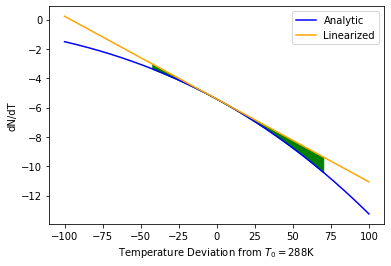

In [ ]:
t0 = 288

def linear_approx(t0=288, dt=100, sigma=sigma, S0=S0):
    dt_steps = np.linspace(-dt, dt, 1000)
    dndt_analytic = -4 * sigma * (dt_steps + t0) ** 3
    dndt_linearized = -4 * sigma * t0 ** 3 - dt_steps * 12 * sigma * t0 ** 2
    return dt_steps, dndt_analytic, dndt_linearized

dt, dndt_an, dndt_lin = linear_approx(t0=t0)

plt.plot(dt, dndt_an, ls='solid', color='blue', label='Analytic')
plt.plot(dt, dndt_lin, ls='solid', color='orange', label='Linearized')
plt.fill_between(dt, dndt_lin, dndt_an, where=np.abs((dndt_lin-dndt_an)/dndt_an) <= 0.1, color='green')
plt.legend()
plt.xlabel(f'Temperature Deviation from $T_0={t0}$K')
plt.ylabel('dN/dT')

# Old Exercise 2

Emissivity 0.6000, Eq. Temp: 287.9110K, Difference: -0.0890K
Emissivity 0.7500, Eq. Temp: 296.1823K, Difference: 8.1823K
Emissivity 0.6750, Eq. Temp: 291.9004K, Difference: 3.9004K
Emissivity 0.6375, Eq. Temp: 289.8714K, Difference: 1.8714K
Emissivity 0.6187, Eq. Temp: 288.8829K, Difference: 0.8829K
Emissivity 0.6094, Eq. Temp: 288.3949K, Difference: 0.3949K
Emissivity 0.6047, Eq. Temp: 288.1525K, Difference: 0.1525K
Emissivity 0.6023, Eq. Temp: 288.0316K, Difference: 0.0316K
Emissivity 0.6012, Eq. Temp: 287.9713K, Difference: -0.0287K
Emissivity 0.6018, Eq. Temp: 288.0015K, Difference: 0.0015K
Required emissivity for 288K: 0.6018
Emissivity 0.6000, Eq. Temp: 287.9110K, Difference: -2.5890K
Emissivity 0.7500, Eq. Temp: 296.1823K, Difference: 5.6823K
Emissivity 0.6750, Eq. Temp: 291.9004K, Difference: 1.4004K
Emissivity 0.6375, Eq. Temp: 289.8714K, Difference: -0.6286K
Emissivity 0.6562, Eq. Temp: 290.8771K, Difference: 0.3771K
Emissivity 0.6469, Eq. Temp: 290.3721K, Difference: -0.1279

Text(0, 0.5, 'Equilibrium temperature [K]')

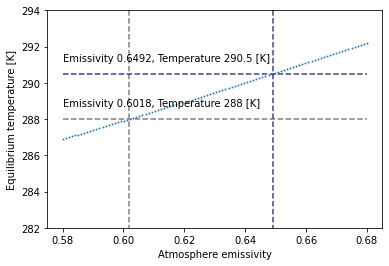

In [ ]:
t_targets = [288, 290.5]
target_emis = np.zeros_like(t_targets)
colors = ['gray', 'darkslateblue']

for i, t_target in enumerate(t_targets):

    emss_low = 0.3
    emss_high = 0.9

    t_dif = 10 # arbitrary starting value, should be higher than value in while condition

    while np.abs(t_dif) > 0.01:
        new_emss = 0.5*(emss_low+emss_high)
        model = ESM(initial_state=255.0, 
                    emissivity=new_emss,
                    use_constant_emissivity=True,
                    use_constant_albedo_land=True,
                    active_components=1)
        
        _, output = model.integrate(sim_time=25., update_state=True, verbose=False)

        t_dif = output['ts'][-1] - t_target
        print(f"Emissivity {new_emss:.4f}, Eq. Temp: {output['ts'][-1]:.4f}K, Difference: {t_dif:.4f}K")

        if t_dif > 0:
            emss_high = new_emss
        else:
            emss_low = new_emss

    print(f"Required emissivity for {t_target}K: {new_emss:.4f}")
    target_emis[i] = new_emss

emss_arr = np.linspace(0.58, 0.68, 100)

temp_eq = np.empty_like(emss_arr)

for i, emss in enumerate(emss_arr):

    model = ESM(initial_state=255.0,
                emissivity=emss,
                use_constant_emissivity=True,
                use_constant_albedo_land=True,
                active_components=1)
    
    _, output = model.integrate(sim_time=25., update_state=True, verbose=False)
    temp_eq[i] = output['ts'][-1]


# tau = 1.0 - 0.5 * emss_arr
plt.scatter(emss_arr, temp_eq, s=0.8)

for i, t in enumerate(t_targets):
    plt.hlines(t, emss_arr.min(), emss_arr.max(), colors=colors[i], linestyles='dashed', label='')
    plt.vlines(target_emis[i], 270., 300., colors=colors[i], linestyles='dashed', label='')
    plt.annotate(f'Emissivity {target_emis[i]:.4f}, Temperature {t} [K]', xy=(emss_arr.min(), t+0.7), xycoords='data')

plt.ylim(282, 294)

plt.xlabel("Atmosphere emissivity")
plt.ylabel("Equilibrium temperature [K]")


# Old Exercise 3 and some general tests

Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  275.0  [K]
Ocean temperature:  265.0  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  0.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  227.00760897359615  [W/m^2]
NRI:  15.315391026403859  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  275.0  [K]
Ocean temperature:  265.0  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  196.5797451164822  [W/m^2]
NRI:  45.74325488351781  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  275.0  [K]
Ocean temperature:  265.0  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  420.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  194.39023353269812  [W/m^2]
NRI:  47.93276646730189  [W/m^2]
DSI:  32.0  [W/m^2]


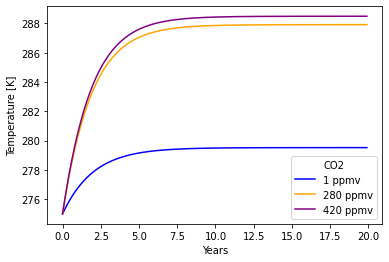

In [ ]:
model = ESM(initial_state={'Ts':275.0, 'Ca':0.}, use_constant_albedo_land=True, albedo_atm=0.0, active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1, update_state=False)
temperature_0 = output['Ts']

print('-------------------------------------------------------------------')

model = ESM(initial_state={'Ts':275.0, 'Ca':280.}, use_constant_albedo_land=True, albedo_atm=0.0, active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1)
temperature_1 = output['Ts']

print('-------------------------------------------------------------------')

model = ESM(initial_state={'Ts':275.0, 'Ca':420.}, use_constant_albedo_land=True, albedo_atm=0.0, active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1)
temperature_2 = output['Ts']

plt.plot(time, temperature_0, ls='solid', color='blue', label="1 ppmv")
plt.plot(time, temperature_1, ls='solid', color='orange', label="280 ppmv")
plt.plot(time, temperature_2, ls='solid', color='purple', label="420 ppmv")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend(title='CO2')

In [ ]:
model = ESM(initial_state={'Ts':275.0, 'Ca':280.}, use_constant_albedo_land=True, albedo_atm=0.0, active_components=3)
model.model_info()
time, output = model.integrate(sim_time=20., out_freq=.1, update_state=True)
print(output)

Running [Atmosphere, Ocean, Carbon] :  3
Surface temperature:  275.0  [K]
Ocean temperature:  265.0  [K]
Surface albedo:  0.3  [-]
Land albedo:  0.3  [-]
CO2:  280.0  [ppmv]
ASR:  238.91  [W/m^2]
OLR:  196.5797451164822  [W/m^2]
NRI:  42.330254883517796  [W/m^2]
DSI:  32.0  [W/m^2]
{'Ts': array([ 2.75000000e+002,  2.75095995e+002,  2.50782900e-292,
        1.30091067e-258,  3.49865759e+159, -1.06827457e-149,
        5.11089057e+173,  3.39394647e-111,  9.08815980e+223,
        5.04041308e+180,  2.21211602e+214,  9.29603063e+199,
       -4.97449437e-246,  2.63597977e+183,  5.29874790e+180,
        6.46336739e+170,  8.75403607e+247,  3.65588262e+233,
        1.38501008e+219,  1.42853560e+248,  0.00000000e+000,
        3.56525721e-306,  5.57771896e+093,  1.66042536e+243,
        2.02647447e+267,  2.44048968e-152,  5.98189660e-154,
        9.30214424e+242,  8.90389807e+252,  6.96411114e+252,
        3.17095868e+180,  3.67197335e+228,  7.48415874e+247,
        6.01347002e-154,  2.63942200e+1

/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  176.96243060738612  [W/m^2]
NRI:  65.36056939261388  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  287.82497051617577  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  242.3230000733949  [W/m^2]
NRI:  -7.339488661273208e-08  [W/m^2]
DSI:  137.03990565176247  [W/m^2]
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  255.0  [K]
Ocean temperature:  245.0  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  176.96243060738612  [W/m^2]
NRI:  65.36056939261388  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------

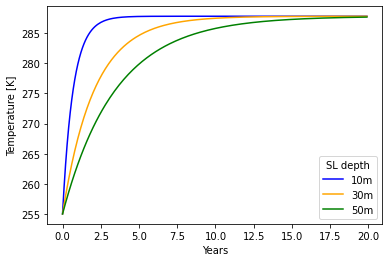

In [ ]:
model = ESM(initial_state=255.0, depth_s=10., active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1, verbose=False)
temperature_0 = output['Ts']

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0, depth_s=30., active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1, verbose=False)
temperature_ = output['Ts']

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=255.0, depth_s=50., active_components=1)

model.model_info()

time, output = model.integrate(sim_time=20., out_freq=.1, verbose=False)
temperature_2 = output['Ts']

print('-------------------------------------------------------------------')
model.model_info()

plt.plot(time, temperature_0, ls='solid', color='blue', label="10m")
plt.plot(time, temperature_1, ls='solid', color='orange', label="30m")
plt.plot(time, temperature_2, ls='solid', color='green', label="50m")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend(title='SL depth')

Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  240.2944712481205  [W/m^2]
NRI:  2.02852875187952  [W/m^2]
DSI:  32.0  [W/m^2]
-------------------------------------------------------------------
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  287.7494117621693  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.29  [-]
Land albedo:  0.29  [-]
CO2:  280.0  [ppmv]
ASR:  242.323  [W/m^2]
OLR:  242.1835735949104  [W/m^2]
NRI:  0.13942640508960835  [W/m^2]
DSI:  35.26211763894171  [W/m^2]
Running [Atmosphere, Ocean, Carbon] :  1
Surface temperature:  286.73  [K]
Ocean temperature:  276.73  [K]
Surface albedo:  0.2673857800481073  [-]
Land albedo:  0.2673857800481073  [-]
CO2:  280.0  [ppmv]
ASR:  250.04123326958097  [W/m^2]
OLR:  240.2944712481205  [W/m^2]
NRI:  9.746762021460484  [W/m^2]
DSI:  32.0  [W/m^2]
-------

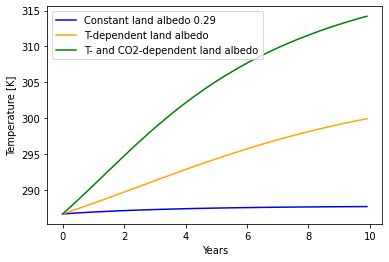

In [ ]:
model = ESM(initial_state=Ts_0, active_components=1)

model.model_info()

time, output = model.integrate(sim_time=10., out_freq=.1, verbose=False)
temperature_0 = output['Ts']

print('-------------------------------------------------------------------')
model.model_info()


model = ESM(initial_state=Ts_0, active_components=1, use_constant_albedo_land=False)

model.model_info()

time, output = model.integrate(sim_time=10., out_freq=.1, verbose=False)
temperature_1 = output['Ts']

print('-------------------------------------------------------------------')
model.model_info()

model = ESM(initial_state=Ts_0, active_components=1,
            use_constant_albedo_land=False,
            use_constant_albedo_icefree=False)


model.model_info()

time, output = model.integrate(sim_time=10., out_freq=.1, verbose=False)
temperature_2 = output['Ts']

print('-------------------------------------------------------------------')
model.model_info()


plt.plot(time, temperature_0, ls='solid', color='blue', label="Constant land albedo 0.29")
plt.plot(time, temperature_1, ls='solid', color='orange', label="T-dependent land albedo")
plt.plot(time, temperature_2, ls='solid', color='green', label="T- and CO2-dependent land albedo")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

# Albedo Exercise 1

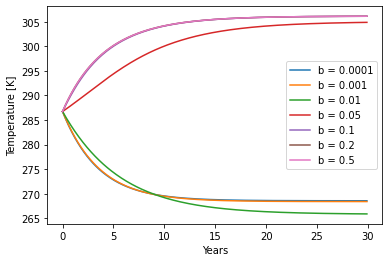

In [ ]:
for param_b in [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5]:
  model = ESM(initial_state=Ts_0, albedo_b=param_b, active_components=1, use_constant_albedo_land=False)

  time, output = model.integrate(sim_time=30., out_freq=.1, verbose=False)
  temperature_0 = output['Ts']

  plt.plot(time, temperature_0, ls='solid', label=f"b = {param_b}")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

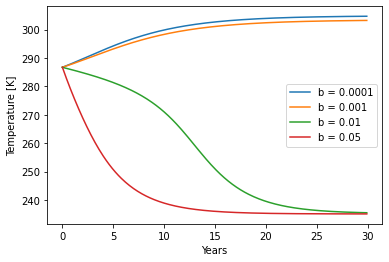

In [ ]:
for param_aco2 in [0.0001, 0.001, 0.01, 0.05]:
  model = ESM(initial_state=Ts_0, albedo_carbon_coeff=param_aco2,
              use_constant_albedo_land=False, use_constant_albedo_icefree=False,
              active_components=1)

  time, output = model.integrate(sim_time=30., out_freq=.1, verbose=False)
  temperature_0 = output['Ts']

  plt.plot(time, temperature_0, ls='solid', label=f"b = {param_aco2}")

plt.xlabel('Years')
plt.ylabel('Temperature [K]')
plt.legend()

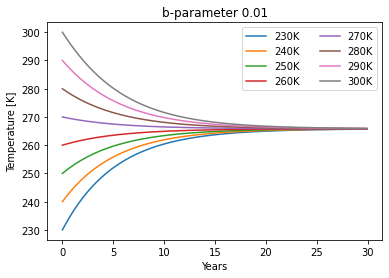

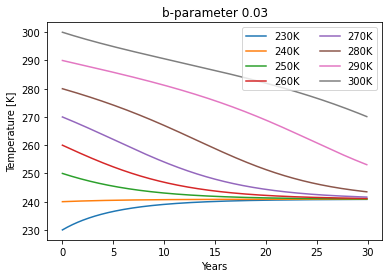

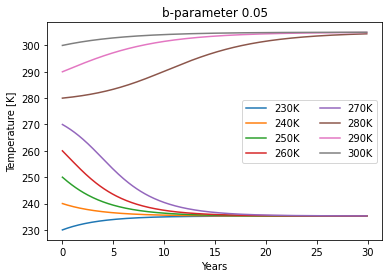

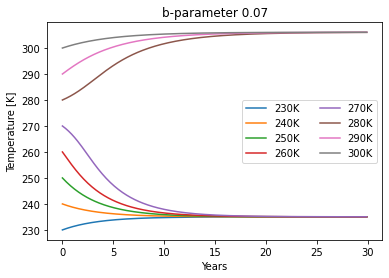

In [ ]:
for albedo_b in [0.01, 0.03, 0.05, 0.07]:
    for t_init in np.arange(230,301,10):
        model = ESM(initial_state=t_init, albedo_b=albedo_b,
                    use_constant_albedo_land=False, active_components=1)

        time, output = model.integrate(sim_time=30., out_freq=.1, verbose=False)
        temperature_0 = output['Ts']

        plt.plot(time, temperature_0, ls='solid', label=f"{t_init}K")


    plt.xlabel('Years')
    plt.ylabel('Temperature [K]')
    plt.title(f'b-parameter {albedo_b}')
    plt.legend(ncol=2)
    plt.show()

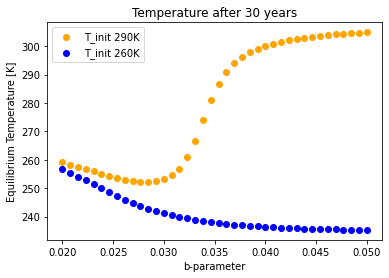

In [ ]:
colors = ['orange', 'blue', 'green']
for i, t_init in enumerate([290, 260]):
    for j, albedo_b in enumerate(np.linspace(0.02, 0.05, 40)):

        model = ESM(initial_state=t_init, albedo_b=albedo_b,
                    use_constant_albedo_land=False, active_components=1)

        time, output = model.integrate(sim_time=30., out_freq=.1, verbose=False)
        temperature_0 = output['Ts']

        if j == 0:
            plt.scatter(albedo_b, temperature_0[-1], c=colors[i], ls='solid', label=f"T_init {t_init}K")
        else:
            plt.scatter(albedo_b, temperature_0[-1], c=colors[i], ls='solid')


plt.xlabel('b-parameter')
plt.ylabel('Equilibrium Temperature [K]')
plt.title('Temperature after 30 years')
plt.legend()
plt.show()

# Albedo Exercise 2

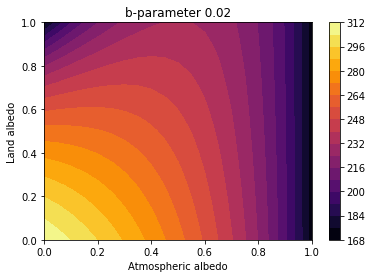

In [ ]:
albedos_atm = np.arange(0,1.01,0.05)
albedos_land = np.arange(0,1.01,0.05)
b_param = 0.02

tequis = np.zeros((len(albedos_atm), len(albedos_land)))

for i, albedo_atm in enumerate(albedos_atm):
    for j, albedo_land in enumerate(albedos_land):
        model = ESM(initial_state=255., albedo_land=albedo_land, albedo_atm=albedo_atm, albedo_b=b_param,
                    active_components=1)

        time, output = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        tequis[i, j] = output['ts'][-1]

plt.contourf(albedos_atm, albedos_land, tequis.T, cmap='inferno', levels=20)
plt.colorbar()

plt.xlabel('Atmospheric albedo')
plt.ylabel('Land albedo')
plt.title(f'b-parameter {b_param}')
plt.show()

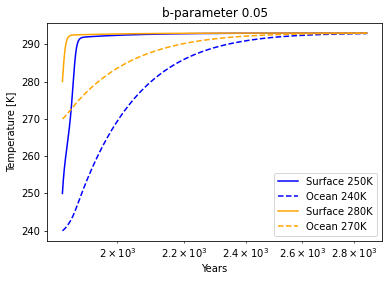

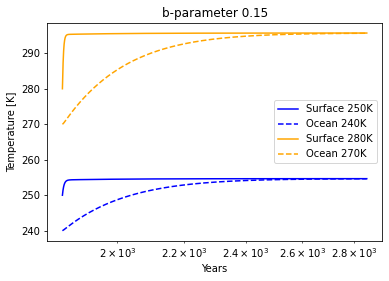

In [ ]:
colors = ['blue', 'orange']

for albedo_b in [0.05, 0.15]:
    for i, t_init in enumerate([250, 280]):
        model = ESM(initial_state=t_init, albedo_b=albedo_b,
                    use_constant_albedo_land=False, active_components=2)

        time, output = model.integrate(sim_time=1000., out_freq=.1, verbose=False)
        temperature_0 = output['ts']
        temperature_1 = output['td']

        plt.semilogx(time, temperature_0, color = colors[i], ls='solid', label=f"Surface {t_init}K")
        plt.semilogx(time, temperature_1, color = colors[i], ls='--', label=f"Ocean {t_init-10}K")


    plt.xlabel('Years')
    plt.ylabel('Temperature [K]')
    plt.title(f'b-parameter {albedo_b}')
    plt.legend()
    plt.show()

# Deep Ocean Exercise 5

In [ ]:
model = ESM(active_components=2)

time, output = model.integrate(sim_time=1000., out_freq=.1, verbose=False)
temperature_0 = output['Ts']
temperature_1 = output['Td']

nri = np.zeros(len(temperature_0))
dsi = np.zeros(len(temperature_1))

for i, (ts, td) in enumerate(zip(temperature_0, temperature_1)):
    nri[i] = model.compute_NRI(ts)
    dsi[i] = model.compute_DSI(ts, td)

plt.scatter(temperature_1, dsi, color='blue', s=1, label='DSI')
plt.scatter(temperature_0, nri, color='orange', s=5, label='NRI')

plt.xlabel('Temperature [K]')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Imbalance vs. Temperature ($\lambda_{\ast}=0$)')
plt.legend()
plt.show()


model = ESM(active_components=2, transient_rad_resp=5)

time, output = model.integrate(sim_time=1000., out_freq=.1, verbose=False)
temperature_0 = output['ts']
temperature_1 = output['td']

nri = np.zeros(len(temperature_0))
dsi = np.zeros(len(temperature_1))

for i, (ts, td) in enumerate(zip(temperature_0, temperature_1)):
    nri[i] = model.compute_NRI(ts, ca_0)
    dsi[i] = model.compute_DSI(ts, td)

plt.scatter(temperature_1, dsi, color='blue', s=1, label='DSI')
plt.scatter(temperature_0, nri, color='orange', s=5, label='NRI')


plt.xlabel('Temperature [K]')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Imbalance vs. Temperature ($\lambda_{\ast}=5$)')
plt.legend()
plt.show()

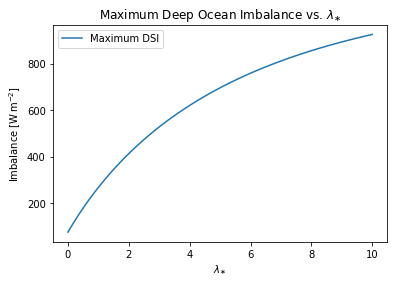

In [ ]:
n = 50
dsi_max = np.zeros(n)

for j, lambda_star in enumerate(np.linspace(0, 100, n)):
    model = ESM(initial_state=(268., 268.), transient_rad_resp=lambda_star)

    time, temperature_0 = model.integrate(sim_time=1000., out_freq=.1, update_state=False, verbose=False)

    dsi = np.zeros(len(temperature_0))

    for i, (ts, td) in enumerate(temperature_0):
        dsi[i] = model.compute_DSI(ts, td)

    dsi_max[j] = np.max(dsi)

plt.plot(np.linspace(0, 10, n), dsi_max, label='Maximum DSI')

plt.xlabel(r'$\lambda_{\ast}$')
plt.ylabel('Imbalance [$\mathrm{W}\,\mathrm{m}^{-2}$]')
plt.title(r'Maximum Deep Ocean Imbalance vs. $\lambda_{\ast}$')
plt.legend()
plt.show()

# Deep Ocean Exercise 6

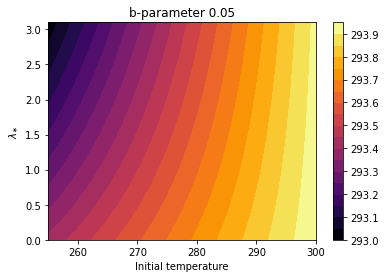

In [ ]:
initial_state = np.linspace(255.0, 300., 25)
lambda_ast = np.linspace(0.0, 3.1, 25)
b_param = 0.05

tequis = np.zeros((len(lambda_ast), len(initial_state)))

for i, tstart in enumerate(initial_state):
    for j, lbd_ast in enumerate(lambda_ast):

        model = ESM(initial_state=[tstart, tstart-10.0], transient_rad_resp=lbd_ast)

        time, Ts = model.integrate(sim_time=30., out_freq=.1, update_state=False, verbose=False)

        tequis[i, j] = Ts[-1, 0]

plt.contourf(initial_state, lambda_ast, tequis.T, cmap='inferno', levels=20)
plt.colorbar()

plt.xlabel('Initial temperature')
plt.ylabel(r'$\lambda_{\ast}$')
plt.title(f'b-parameter {b_param}')
plt.show()

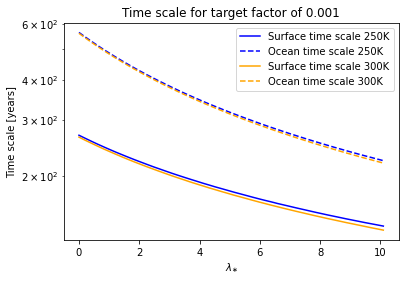

In [ ]:
colors = ['blue', 'orange', 'black']
rad_response = np.linspace(0., 10.1, 50)

eq_timescale=5000.
target_factor=0.001

time_scale_s = np.zeros_like(rad_response)
time_scale_d = np.zeros_like(rad_response)

for i, t_init in enumerate([250, 300]):

    for j, lbd_ast in enumerate(rad_response):

        model = ESM(initial_state=(t_init, t_init), transient_rad_resp=lbd_ast, mixing_scale=6.0)

        time, temp = model.integrate(sim_time=eq_timescale, out_freq=.1, update_state=False, verbose=False)

        temp_s = temp[:, 0]
        temp_d = temp[:, 1]
        
        time_scale_s[j] = time[np.abs(temp_s - temp_s[-1]) < np.abs(temp_s[0] - temp_s[-1])*target_factor][0]
        time_scale_d[j] = time[np.abs(temp_d - temp_d[-1]) < np.abs(temp_d[0] - temp_d[-1])*target_factor][0]

    plt.semilogy(rad_response, time_scale_s, color = colors[i], ls='solid', label=f"Surface time scale {t_init}K")
    plt.semilogy(rad_response, time_scale_d, color = colors[i], ls='--', label=f"Ocean time scale {t_init}K")

plt.ylabel('Time scale [years]')
plt.xlabel(r'$\lambda_{\ast}$')
plt.title(f'Time scale for target factor of {target_factor}')
plt.legend()
plt.show()

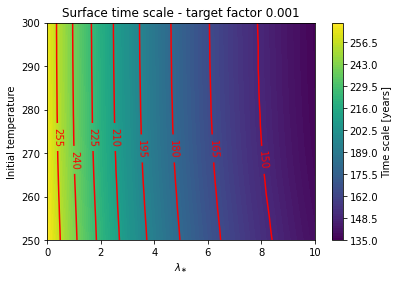

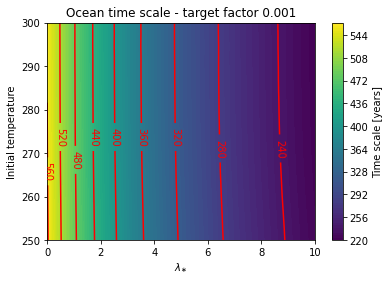

In [ ]:
rad_response = np.linspace(0., 10., 50)
t_inits = np.linspace(250., 300., 20)

eq_timescale=1000.
target_factor=0.001

time_scale_s = np.zeros((len(t_inits), len(rad_response)))
time_scale_d = np.zeros((len(t_inits), len(rad_response)))

for i, t_init in enumerate(t_inits):

    for j, lbd_ast in enumerate(rad_response):

        model = ESM(initial_state=(t_init, t_init), transient_rad_resp=lbd_ast, mixing_scale=6.0)

        time, temp = model.integrate(sim_time=eq_timescale, out_freq=.1, update_state=False, verbose=False)

        temp_s = temp[:, 0]
        temp_d = temp[:, 1]
        
        time_scale_s[i, j] = time[np.abs(temp_s - temp_s[-1]) < np.abs(temp_s[0] - temp_s[-1])*target_factor][0]
        time_scale_d[i, j] = time[np.abs(temp_d - temp_d[-1]) < np.abs(temp_d[0] - temp_d[-1])*target_factor][0]

plt.contourf(rad_response, t_inits, time_scale_s, cmap='viridis', levels=100)
plt.colorbar(label='Time scale [years]')
contour = plt.contour(rad_response, t_inits, time_scale_s, colors='red', levels=10)
plt.clabel(contour, colors='red', fmt='%1.0f')

plt.xlabel(r'$\lambda_{\ast}$')
plt.ylabel('Initial temperature')
plt.title(f'Surface time scale - target factor {target_factor}')
plt.show()

plt.contourf(rad_response, t_inits, time_scale_d, cmap='viridis', levels=100)
plt.colorbar(label='Time scale [years]')
contour = plt.contour(rad_response, t_inits, time_scale_d, colors='red', levels=10)
plt.clabel(contour, colors='red', fmt='%1.0f')

plt.xlabel(r'$\lambda_{\ast}$')
plt.ylabel('Initial temperature')
plt.title(f'Ocean time scale - target factor {target_factor}')
plt.show()

# Emission Scenarios

Text(0, 0.5, '$\\Delta\\,T$ from 1850-1900 mean')

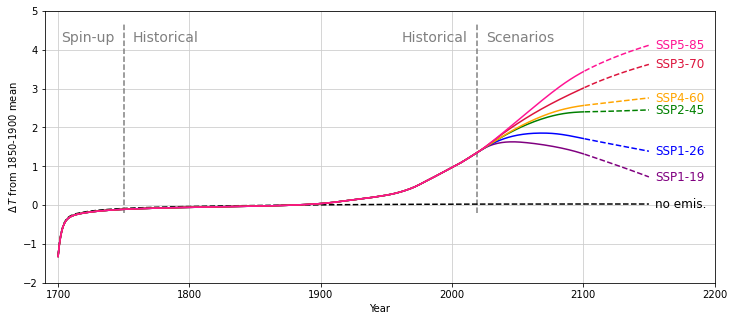

In [ ]:
scenarios = ['ssp1-19','ssp1-26', 'ssp2-45', 'ssp4-60', 'ssp3-70', 'ssp5-85']
paths = [f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{s}.txt' for s in scenarios]
colors = ['purple',  'blue', 'green', 'orange', 'crimson', 'deeppink']

first_year = 1700.
years = np.arange(first_year, 2151., 1)

fig, ax = plt.subplots(figsize=(12,5))

model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                use_constant_albedo_land=True,
                emissivity_gradient=0.01,
                emissions_scenario=0.,
                active_components=3)
    
time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

tequil = np.mean(output['ts'][(time>=1850.) & (time<=1900)])
ax.plot(time[time>=first_year], output['ts'][time>=first_year]-tequil, color='black', linestyle='dashed')
ax.text(2155, output['ts'][-1]-tequil, 'no emis.', ha='left', va='center', color='black', fontsize=12)

for i, scenario in enumerate(scenarios):

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                use_constant_albedo_land=True,
                emissivity_gradient=0.01,
                emissions_scenario=paths[i],
                active_components=3)
    
    time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

    tequil = np.mean(output['ts'][(time>=1850.) & (time<=1900)])
    ax.plot(time[(time>=first_year) & (time<=2100.)], output['ts'][(time>=first_year) & (time<=2100.)]-tequil, color=colors[i])
    ax.plot(time[time>2100.], output['ts'][time>2100.]-tequil, color=colors[i], linestyle='--')
    ax.text(2155, output['ts'][-1]-tequil, scenario.upper(), ha='left', va='center', color=colors[i], fontsize=12)

ax.vlines(2019, -0.2, 4.7, colors='0.5', linestyles='--')
ax.text(2012, 4.2, 'Historical', ha='right', color='0.5', fontsize=14)
ax.text(2026, 4.2, 'Scenarios', ha='left', color='0.5', fontsize=14)

ax.vlines(1750, -0.2, 4.7, colors='0.5', linestyles='--')
ax.text(1743, 4.2, 'Spin-up', ha='right', color='0.5', fontsize=14)
ax.text(1757, 4.2, 'Historical', ha='left', color='0.5', fontsize=14)

ax.set_xlim(first_year-10, 2200)
ax.set_ylim(-2, 5)
ax.grid(color='0.8')

ax.set_xlabel('Year')
ax.set_ylabel('$\Delta\,T$ from 1850-1900 mean')



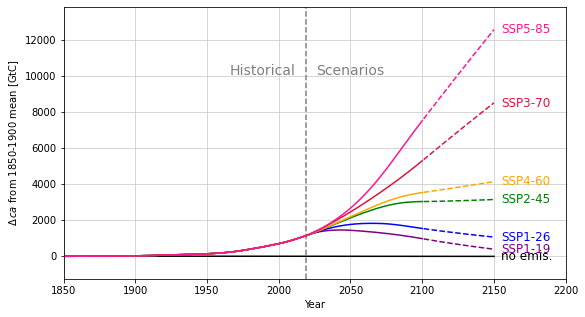

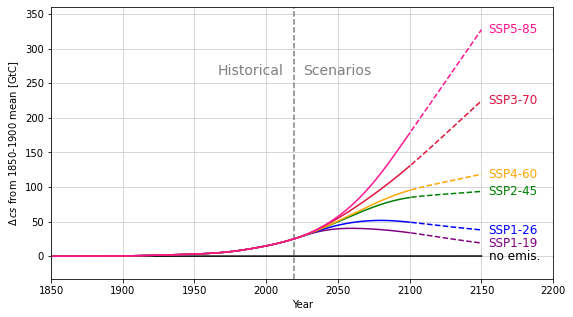

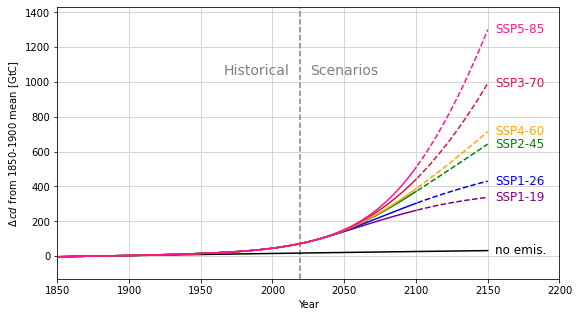

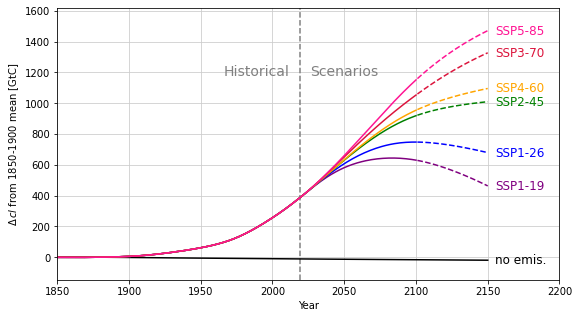

In [ ]:
scenarios = ['ssp1-19','ssp1-26', 'ssp2-45', 'ssp4-60', 'ssp3-70', 'ssp5-85']
paths = [f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{s}.txt' for s in scenarios]
colors = ['purple',  'blue', 'green', 'orange', 'crimson', 'deeppink']
years = np.arange(1650., 2151., 1)
first_year = 1850.

## model init
use_constant_albedo_land = True
use_constant_albedo_icefree = True
# mixing_scale = 3.2
# albedo_b=0.1
# albedo_carbon_coeff=-0.01

for c in ['ca', 'cs', 'cd', 'cl']:

    ymax = 0

    fig, ax = plt.subplots(figsize=(9,5))

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                    emissions_scenario=0.,
                    use_constant_albedo_land=use_constant_albedo_land,
                    use_constant_albedo_icefree=use_constant_albedo_icefree,
                    active_components=3)
        
    time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

    tequil = np.mean(output[c][(time>=1850.) & (time<=1900)])
    ax.plot(time[time>=first_year], output[c][time>=first_year] -tequil, color='black')
    ax.text(2155, output[c][-1]-tequil, 'no emis.', ha='left', va='center', color='black', fontsize=12)

    for i, scenario in enumerate(scenarios):

        model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                    emissions_scenario=paths[i],
                    use_constant_albedo_land=use_constant_albedo_land,
                    use_constant_albedo_icefree=use_constant_albedo_icefree,
                    active_components=3)
        
        time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)

        tequil = np.mean(output[c][(time>=1850.) & (time<=1900)])
        ax.plot(time[(time>=first_year) & (time<=2100.)], output[c][(time>=first_year) & (time<=2100.)]-tequil, color=colors[i])
        ax.plot(time[time>2100.], output[c][time>2100.]-tequil, color=colors[i], linestyle='--')
        ax.text(2155, output[c][-1]-tequil, scenario.upper(), ha='left', va='center', color=colors[i], fontsize=12)

        if np.max(output[c]-tequil) > ymax:
            ymax = np.max(output[c]-tequil)

    ax.set_xlim(first_year, 2200)
    ax.set_ylim(-ymax*0.1, ymax*1.1)
    ax.grid(color='0.8')

    ax.vlines(2019, ax.get_ylim()[0], ax.get_ylim()[1], colors='0.5', linestyles='--')
    ax.text(2012, ymax*0.8, 'Historical', ha='right', color='0.5', fontsize=14)
    ax.text(2026, ymax*0.8, 'Scenarios', ha='left', color='0.5', fontsize=14)

    ax.set_xlabel('Year')
    ax.set_ylabel(f'$\Delta\,{c}$ from 1850-1900 mean [GtC]')

    plt.savefig(f'scenarios_{c}_constalbedo_short.png', dpi=200)
    plt.show()


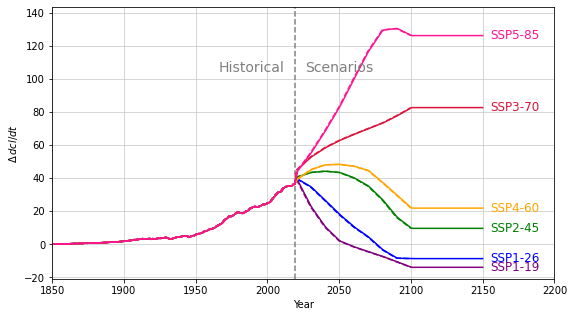

In [ ]:
scenarios = ['ssp1-19','ssp1-26', 'ssp2-45', 'ssp4-60', 'ssp3-70', 'ssp5-85']
paths = [f'https://raw.githubusercontent.com/dkrieger94/intro/master/scen/{s}.txt' for s in scenarios]
colors = ['purple',  'blue', 'green', 'orange', 'crimson', 'deeppink']
years = np.arange(1650., 2151., 1)
first_year = 1850.

## model init
use_constant_albedo_land = True
use_constant_albedo_icefree = False
# mixing_scale = 3.2
# albedo_b=0.1
# albedo_carbon_coeff=-0.01


ymax = 0
ymin = 0

fig, ax = plt.subplots(figsize=(9,5))

model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissions_scenario=0.,
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
# time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)
# output_c = output[c][time>=first_year][1:] - output[c][time>=first_year][:-1]
# ax.plot(time[time>=first_year+1], output_c, color='black')
# ax.text(2155, output[c][-1]-output[c][-2], 'no emis.', ha='left', va='center', color='black', fontsize=12)

for i, scenario in enumerate(scenarios):

    model = ESM(initial_state={'ts': Ts_0, 'td': Ts_0 - 10., 'ca': 280},
                emissions_scenario=paths[i],
                use_constant_albedo_land=use_constant_albedo_land,
                use_constant_albedo_icefree=use_constant_albedo_icefree,
                active_components=3)
    
    time, output = model.integrate(sim_time=years, out_freq=1., update_state=True, is_relative_time=False, verbose=False)
    
    for j, c in enumerate(['ca', 'cs', 'cd', 'cl']):
        if j == 0:
            output_c = output[c][time>=first_year][1:] - output[c][time>=first_year][:-1]
        else:
            output_c += output[c][time>=first_year][1:] - output[c][time>=first_year][:-1]

    ax.plot(time[time>=first_year+1], output_c, color=colors[i])

    em_data = np.array(pd.read_csv(paths[i], sep=',')).T
    ax.plot(*em_data, color=colors[i], linestyle='dashed')


    ax.text(2155, output_c[-1], scenario.upper(), ha='left', va='center', color=colors[i], fontsize=12)

    if np.max(output_c) > ymax:
        ymax = np.max(output_c)

    if np.min(output_c) < ymin:
        ymin = np.min(output_c)

ax.set_xlim(first_year, 2200)
ax.set_ylim(ymin*1.5, ymax*1.1)
ax.grid(color='0.8')

ax.vlines(2019, ax.get_ylim()[0], ax.get_ylim()[1], colors='0.5', linestyles='--')
ax.text(2012, ymax*0.8, 'Historical', ha='right', color='0.5', fontsize=14)
ax.text(2026, ymax*0.8, 'Scenarios', ha='left', color='0.5', fontsize=14)

ax.set_xlabel('Year')
ax.set_ylabel(f'$\Delta\,d{c}/dt$')

plt.savefig(f'scenarios_dcdt_varyingalbedo_short.png', dpi=200)
plt.show()


In [ ]:
model.ts

292.16824782056506